<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ME539-Scientific-Machine-Learning/blob/main/Shaunak_Mukherjee_ME539_homework_06_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6

## References

+ Lectures 21-23 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

If on Google Colab, install the following packages:

In [ ]:
!pip install gpytorch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
from gpytorch.kernels import RBFKernel, ScaleKernel
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = kernel_func.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5,
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);


import gpytorch

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**

## Problem 1 - Defining priors on function spaces

In this problem, we will explore further how Gaussian processes can be used to define probability measures over function spaces.
To this end, assume that there is a 1D function, call if $f(x)$, which we do not know.
For simplicity, assume that $x$ takes values in $[0,1]$.
We will employ Gaussian process regression to encode our state of knowledge about $f(x)$ and sample some possibilities.
For each of the cases below:
+ Assume that $f\sim \operatorname{GP}(m, k)$ and pick a mean ($m(x)$) and a covariance function $f(x)$ that match the provided information.
+ Write code that samples a few times (up to five) the values of $f(x)$ at 100 equidistant points between 0 and 1.

### Part A - Super smooth function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -4 and 4.

**Answer:**

**I am doing this for you so that you have a concrete example of what is requested.**

The mean function should be:

$$
m(x) = 0.
$$

The covariance function should be a squared exponential:

$$
k(x,x') = s^2\exp\left\{-\frac{(x-x')^2}{2\ell^2}\right\},
$$

with variance:

$$
s^2 = k(x,x) = \mathbb{V}[f(x)] = 4,
$$

and lengthscale $\ell = 0.1$.
We chose the variance to be 4.0 so that with (about) 95% probability, the values of $f(x)$ are between -4 and 4.

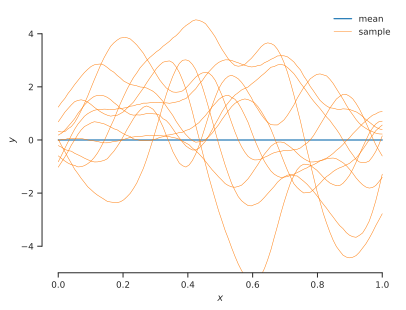

In [ ]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 4.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part B - Super smooth function with known ultra-small length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.05$.
+ You think that $f(x)$ is between -3 and 3.

**Answer:**

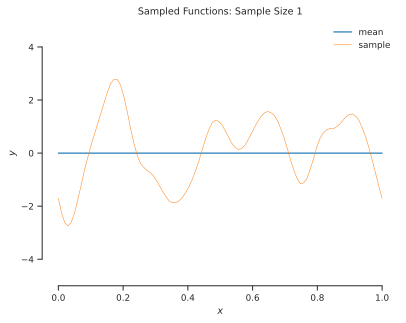

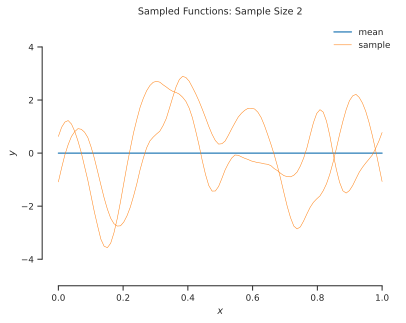

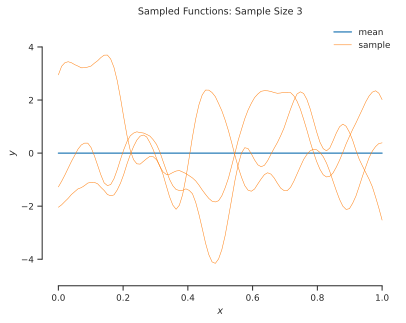

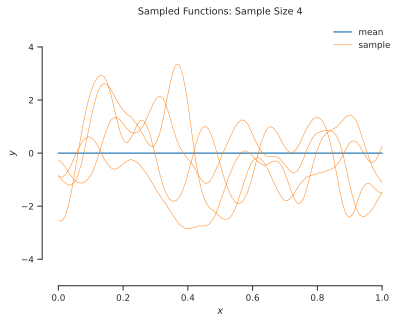

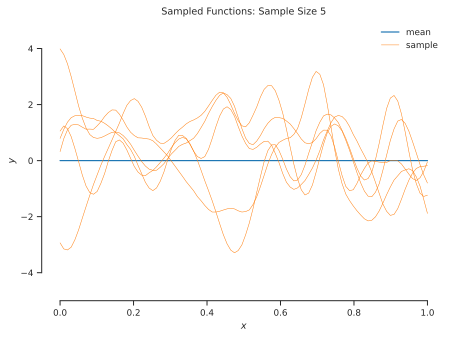

In [ ]:
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define # of samples needed
max_sample = 5

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = (3 / 2) ** 2 # Here, 2 * sigma = 3 so, var = (sigma)^2
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions for sample sizes 1 to 5
for sample_size in range(1, max_sample+1):
    sample_functions(mean, k, nugget=1e-4, num_samples=sample_size, num_test=100)
    plt.title(f'Sampled Functions: Sample Size {sample_size}')
plt.tight_layout()

### Part C - Continuous function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is continuous, nowhere differentiable.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.MaternKernel`` with $\nu=1/2$.

**Answer:**

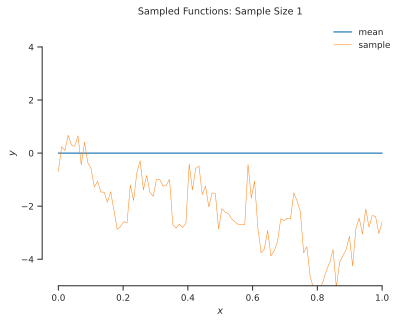

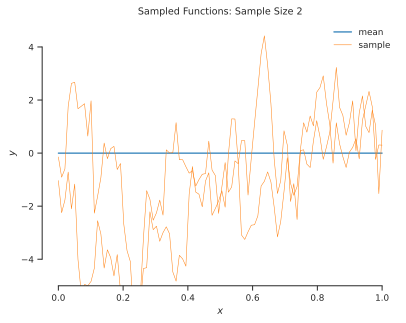

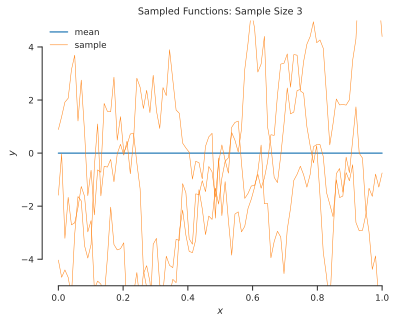

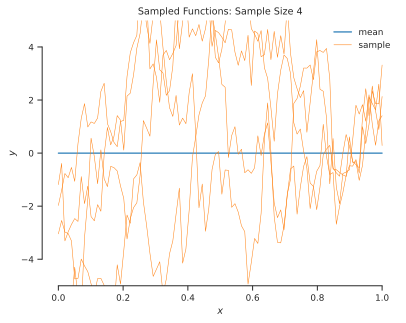

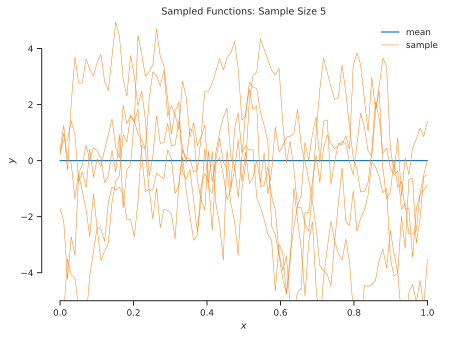

In [ ]:
from gpytorch.kernels import MaternKernel, ScaleKernel

# Define # of samples needed
max_sample = 5

# Define the covariance function
k = ScaleKernel(MaternKernel(nu=1/2))

k.outputscale = (5 / 2) ** 2 # Here, 2 * sigma = 5 so, var = (sigma)^2
k.base_kernel.lengthscale = 0.1

mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions for sample sizes 1 to 5
for sample_size in range(1, max_sample+1):
    sample_functions(mean, k, nugget=1e-4, num_samples= sample_size, num_test=100)

    plt.title(f'Sampled Functions: Sample Size {sample_size}')
plt.tight_layout()

### Part D - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.5$ of the period.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.

**Answer:**

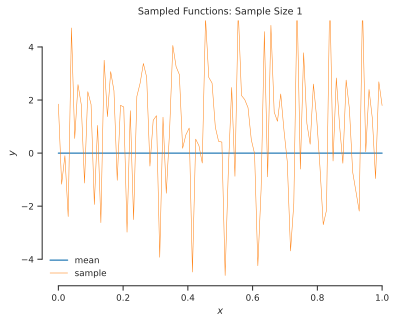

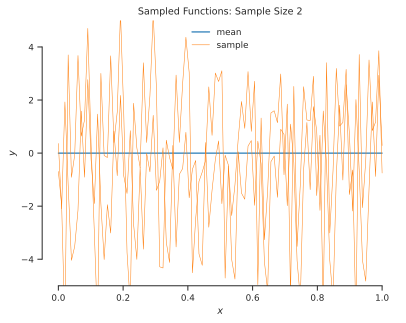

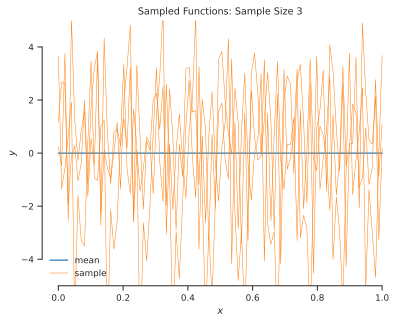

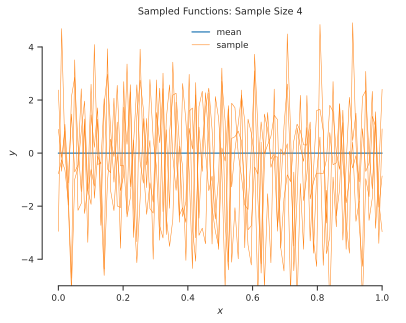

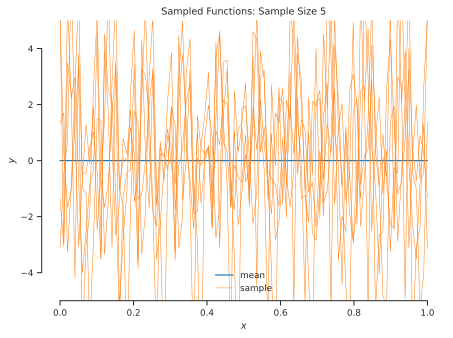

In [ ]:
from gpytorch.kernels import PeriodicKernel

max_sample = 5

# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.outputscale = (5 / 2) ** 2 # Here, 2 * sigma = 5 so, var = (sigma)^2
period_length = 0.1
k.base_kernel.lengthscale = 0.5 * period_length
k.base_kernel.period_length = period_length
# Define the mean
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0


# Sample functions for sample sizes 1 to 5
for sample_size in range(1, max_sample+1):
    sample_functions(mean, k, nugget=1e-3, num_samples=sample_size)

    plt.title(f'Sampled Functions: Sample Size {sample_size}')
plt.tight_layout()


### Part E - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$ of the period (**the only thing that is different compared to D**).
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.


**Answer:**

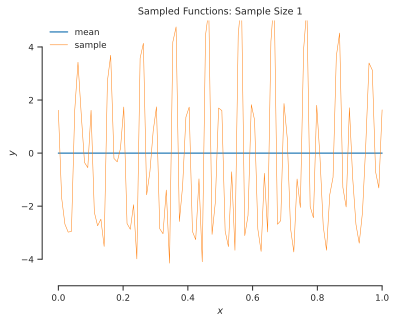

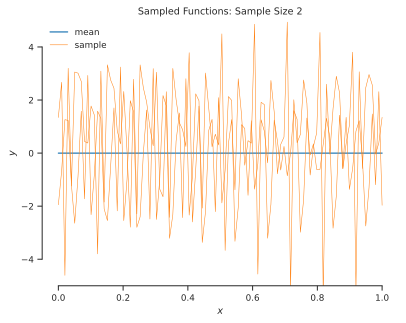

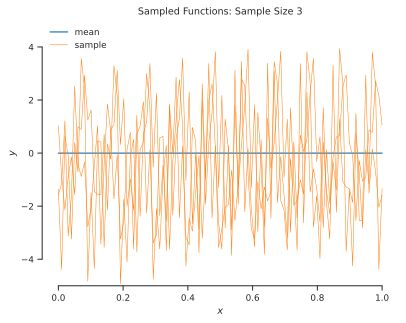

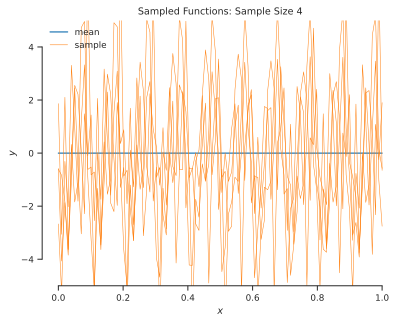

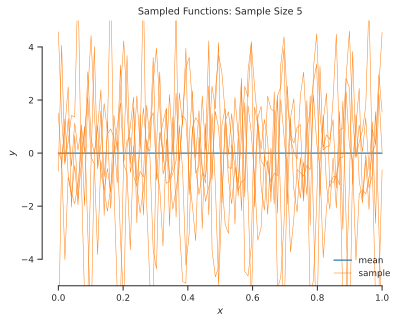

<Figure size 640x480 with 0 Axes>

In [ ]:
from gpytorch.kernels import PeriodicKernel, ScaleKernel

# Define max number of samples
max_sample = 5

# Define the covariance function
k = ScaleKernel(PeriodicKernel())

# Define the variance such that 2 * sigma = 5
k.outputscale = (5 / 2) ** 2
period_length = 0.1
k.base_kernel.lengthscale = 0.1
k.base_kernel.period_length = period_length

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions for sample sizes 1 to 5
for sample_size in range(1, max_sample+1):
    sample_functions(mean, k, nugget=5e-4, num_samples= sample_size, num_test=100)

    plt.title(f'Sampled Functions: Sample Size {sample_size}')
    plt.show()
plt.tight_layout()


### Part F - The sum of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x) + f_2(x)$, where:
    - $f_1(x)$ is smooth with variance 2 and length scale 0.5
    - $f_2(x)$ is continuous, nowhere differentiable with variance 0.1 and length scale 0.1

Hint: Use must create a new covariance function that is the sum of two other covariances.

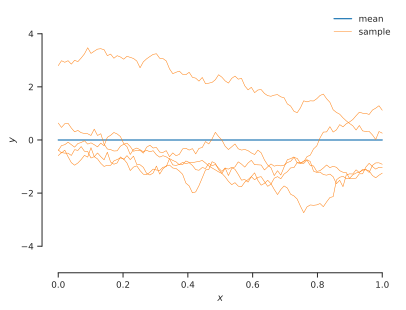

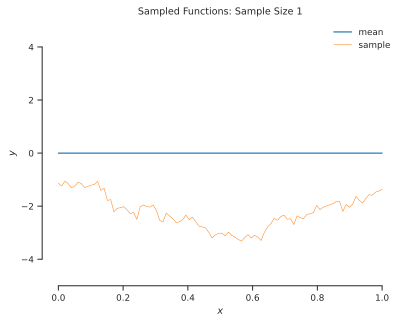

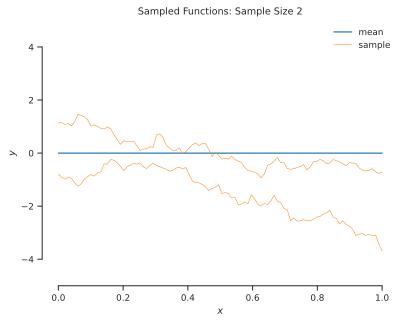

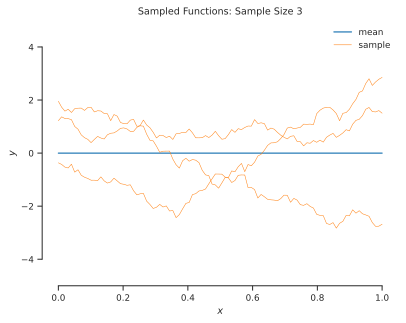

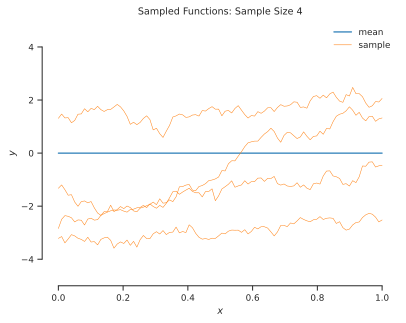

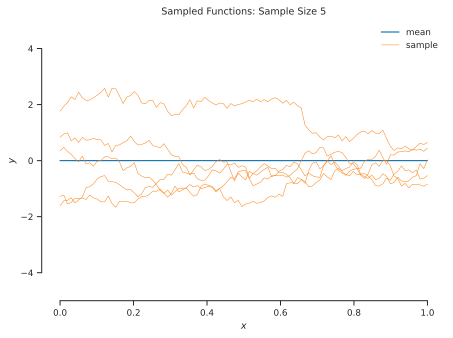

In [ ]:
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel

# Define max number of samples
max_sample = 5

# Define the covariance function for f1
k1 = ScaleKernel(RBFKernel())
k1.outputscale = 2
k1.base_kernel.lengthscale = 0.5

# Define the covariance function for f2
k2 = ScaleKernel(MaternKernel(nu=0.5))
k2.outputscale = 0.1
k2.base_kernel.lengthscale = 0.1

# Define the combined covariance function
k = k1 + k2

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

sample_functions(mean, k, nugget=1e-4, num_samples=5)


# Sample functions for sample sizes 1 to 5
for sample_size in range(1, max_sample+1):
    sample_functions(mean, k, nugget=1e-4, num_samples= sample_size)

    plt.title(f'Sampled Functions: Sample Size {sample_size}')
plt.tight_layout()

### Part G - The product of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x)f_2(x)$, where:
    - $f_1(x)$ is smooth, periodic (period = 0.1), length scale 0.1 (relative to the period), and variance 2.
    - $f_2(x)$ is smooth with length scale 0.5 and variance 1.

Hint: Use must create a new covariance function that is the product of two other covariances.

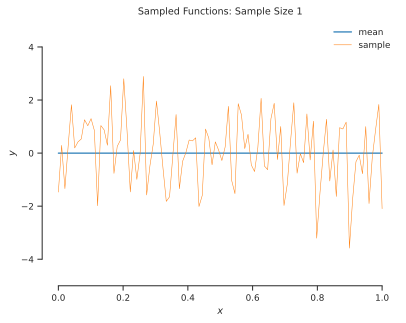

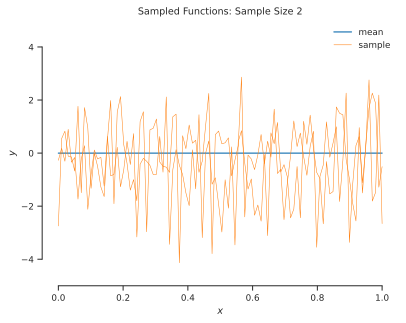

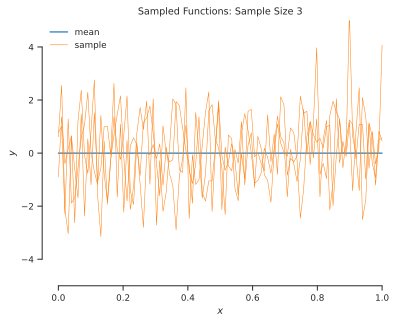

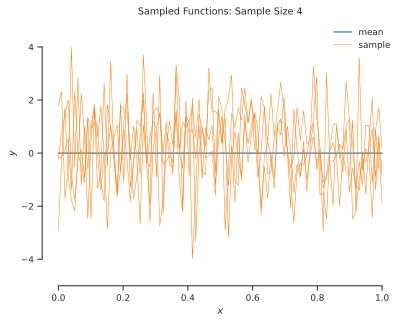

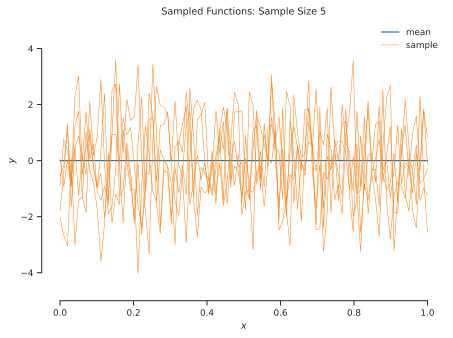

In [ ]:
from gpytorch.kernels import PeriodicKernel, RBFKernel, ScaleKernel, ProductKernel

# Define max number of samples
max_sample

# Define the covariance function for f1
k1 = ScaleKernel(PeriodicKernel())
period_length = 0.1
k1.outputscale = 2
k1.base_kernel.lengthscale = 0.1 * period_length
k1.base_kernel.period_length = period_length

# Define the covariance function for f2
k2 = ScaleKernel(RBFKernel())
k2.outputscale = 1
k2.base_kernel.lengthscale = 0.5

# Define the combined covariance function (product of k1 and k2)
k = ProductKernel(k1, k2)

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions for sample sizes 1 to 5
for sample_size in range(1, max_sample + 1):
    sample_functions(mean, k, nugget=1e-4, num_samples=sample_size, num_test=100)
    plt.title(f'Sampled Functions: Sample Size {sample_size}')
plt.tight_layout()

## Problem 2

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start in March 1958 and go back to January 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python cell below downloads and plots the data set.

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/mauna_loa_co2.txt"
download(url)

In [ ]:
data = np.loadtxt('mauna_loa_co2.txt')

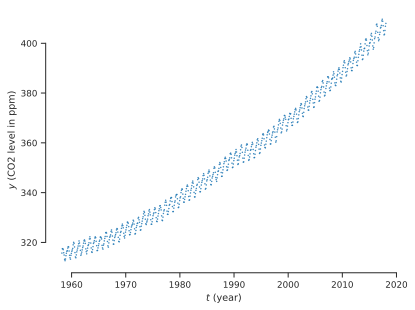

In [ ]:
#load data
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, 1)
ax.plot(t, y, '.', markersize=1)
ax.set_xlabel('$t$ (year)')
ax.set_ylabel('$y$ (CO2 level in ppm)')
sns.despine(trim=True);

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since most of the population inhabits the northern hemisphere, fuel consumption increases during the northern winters, and CO2 emissions follow. Our goal is to study this dataset with Gaussian process regression. Specifically, we would like to predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 and quantify our uncertainty about this prediction.

Working with a scaled version of the inputs and outputs is always a good idea. We are going to scale the times as follows:

$$
t_s = t - t_{\min}.
$$

So, time is still in fractional years, but we start counting at zero instead of 1950.
We scale the $y$'s as:

$$
y_s = \frac{y - y_{\min}}{y_{\max}-y_{\min}}.
$$

This takes all the $y$ between $0$ and $1$.
Here is what the scaled data look like:

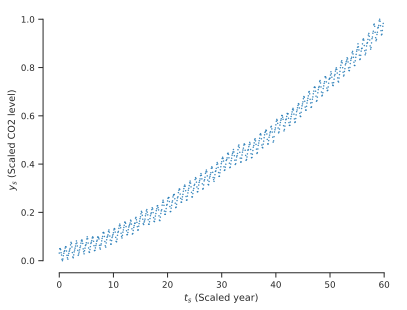

In [ ]:
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
fig, ax = plt.subplots(1, 1)
ax.plot(t_s, y_s, '.', markersize=1)
ax.set_xlabel('$t_s$ (Scaled year)')
ax.set_ylabel('$y_s$ (Scaled CO2 level)')
sns.despine(trim=True);

Work with the scaled data in what follows as you develop your model.
Scale back to the original units for your final predictions.

## Part A - Naive approach

Use a zero mean Gaussian process with a squared exponential covariance function to fit the data and make the required prediction (ten years after the last observation).

**Answer:**

**Again, this is done for you so that you have a concrete example of what is requested.**

In [ ]:
# Define gaussian model class
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
cov_module = ScaleKernel(RBFKernel())
mean_module = gpytorch.means.ConstantMean()
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
naive_model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(naive_model, train_x, train_y)

tensor(0.8545, grad_fn=<NegBackward0>)
tensor(0.7392, grad_fn=<NegBackward0>)
tensor(-0.5164, grad_fn=<NegBackward0>)
tensor(-1.7416, grad_fn=<NegBackward0>)
tensor(-2.1096, grad_fn=<NegBackward0>)
tensor(-2.2474, grad_fn=<NegBackward0>)
tensor(-2.0077, grad_fn=<NegBackward0>)
tensor(-2.2916, grad_fn=<NegBackward0>)
tensor(-2.3049, grad_fn=<NegBackward0>)
tensor(-2.3148, grad_fn=<NegBackward0>)
tensor(-2.3302, grad_fn=<NegBackward0>)
tensor(-2.3334, grad_fn=<NegBackward0>)
tensor(-2.2765, grad_fn=<NegBackward0>)
tensor(-2.3378, grad_fn=<NegBackward0>)
tensor(-2.3401, grad_fn=<NegBackward0>)
tensor(-2.3438, grad_fn=<NegBackward0>)
tensor(-2.3462, grad_fn=<NegBackward0>)
tensor(-2.3476, grad_fn=<NegBackward0>)
tensor(-2.3480, grad_fn=<NegBackward0>)
tensor(-2.3498, grad_fn=<NegBackward0>)
tensor(-2.3520, grad_fn=<NegBackward0>)
tensor(-2.3525, grad_fn=<NegBackward0>)
tensor(-2.3527, grad_fn=<NegBackward0>)
tensor(-2.3540, grad_fn=<NegBackward0>)
tensor(-2.3540, grad_fn=<NegBackward0>)
te

Predict everything:

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


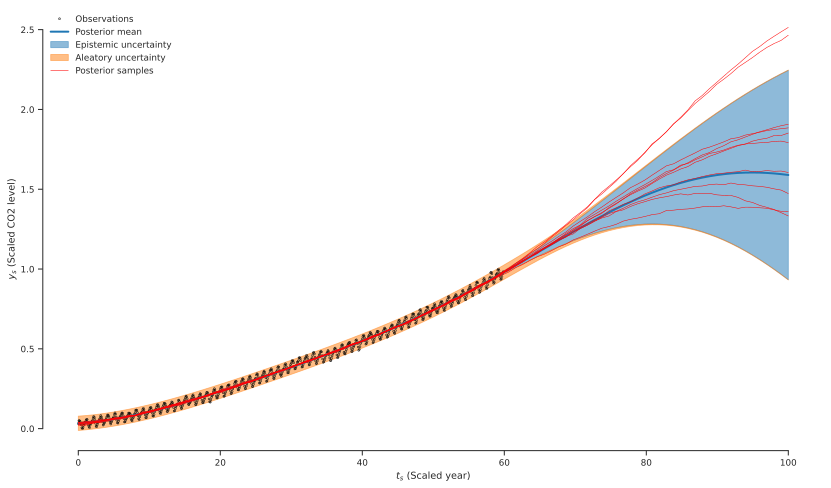

In [ ]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=naive_model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

Notice that the squared exponential covariance captures the long terms but fails to capture the seasonal fluctuations. The seasonal fluctuations are treated as noise. This is wrong. You will have to fix this in the next part.

## Part B - Improving the prior covariance

Now, use the ideas of Problem 1 to develop a covariance function that exhibits the following characteristics visible in the data (call $f(x)$ the scaled CO2 level.
+ $f(x)$ is smooth.
+ $f(x)$ has a clear trend with a multi-year length scale.
+ $f(x)$ has seasonal fluctuations with a period of one year.
+ $f(x)$ exhibits small fluctuations within its period.

There is more than one correct answer.

**Answer:**

Since there is more than one correct answer, I have shown here 2 models with increasing complexity by adding more kernels.

tensor(1.0355, grad_fn=<NegBackward0>)
tensor(0.9562, grad_fn=<NegBackward0>)
tensor(0.2462, grad_fn=<NegBackward0>)
tensor(468338.6562, grad_fn=<NegBackward0>)
tensor(9.4125, grad_fn=<NegBackward0>)
tensor(-0.0169, grad_fn=<NegBackward0>)
tensor(-0.1426, grad_fn=<NegBackward0>)
tensor(-0.7596, grad_fn=<NegBackward0>)
tensor(-0.6755, grad_fn=<NegBackward0>)
tensor(-1.4849, grad_fn=<NegBackward0>)
tensor(-1.3073, grad_fn=<NegBackward0>)
tensor(-2.4966, grad_fn=<NegBackward0>)
tensor(-1.7408, grad_fn=<NegBackward0>)
tensor(-2.5566, grad_fn=<NegBackward0>)
tensor(-2.6271, grad_fn=<NegBackward0>)
tensor(-2.8923, grad_fn=<NegBackward0>)
tensor(-2.9141, grad_fn=<NegBackward0>)
tensor(-2.9467, grad_fn=<NegBackward0>)
tensor(-2.9829, grad_fn=<NegBackward0>)
tensor(-3.0021, grad_fn=<NegBackward0>)
tensor(-3.0123, grad_fn=<NegBackward0>)
tensor(-3.0208, grad_fn=<NegBackward0>)
tensor(-3.0389, grad_fn=<NegBackward0>)
tensor(-3.1195, grad_fn=<NegBackward0>)
tensor(-3.1603, grad_fn=<NegBackward0>)


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


tensor(-2.1135, grad_fn=<NegBackward0>)
tensor(-3.2127, grad_fn=<NegBackward0>)
tensor(-3.2335, grad_fn=<NegBackward0>)
tensor(-3.2353, grad_fn=<NegBackward0>)
tensor(-3.2361, grad_fn=<NegBackward0>)
tensor(-3.2377, grad_fn=<NegBackward0>)
tensor(-3.2366, grad_fn=<NegBackward0>)
tensor(-3.2380, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2377, grad_fn=<NegBackward0>)
tensor(-3.2374, grad_fn=<NegBackward0>)
tensor(-3.2391, grad_fn=<NegBackward0>)
tensor(-3.2392, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2394, grad_fn=<NegBackward0>)
Iter   2/10 - Loss: -3.160
tensor(-3.2394, grad_fn=<NegBackward0>)
tensor(-3.2377, grad_fn=<NegBackward0>)
tensor(-3.2374, grad_fn=<NegBackward0>)
tensor(-3.2391, grad_fn=<NegBackward0>)
tensor(-3.2392, grad_fn=<NegBackward0>)
tensor(-3.239

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/operators/_linear_operator.py:2155: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


Text(0.5, 1.0, 'Expert Model 1 with Prediction Performance')

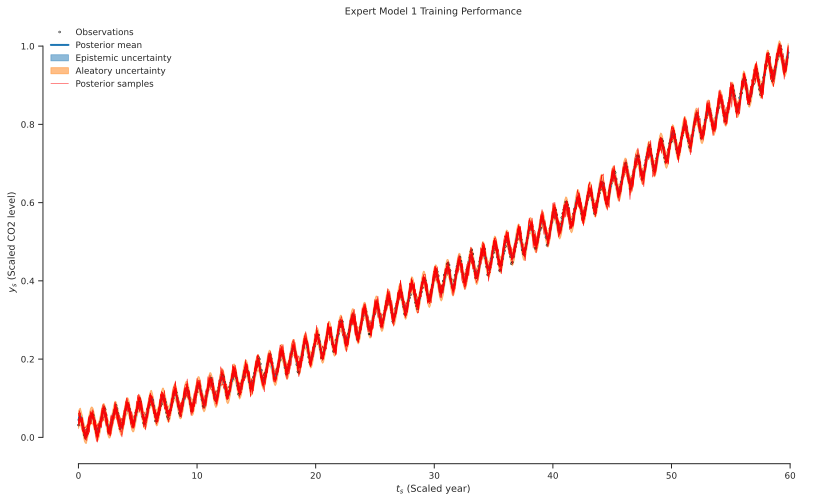

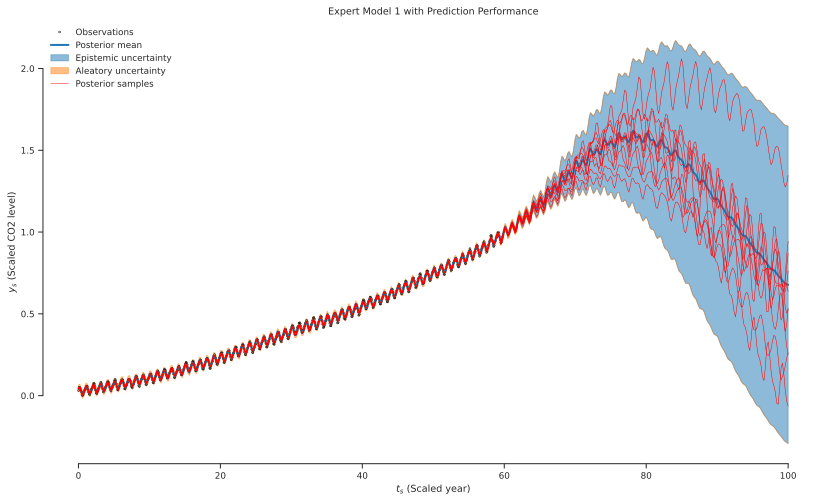

In [ ]:
# A more simpler model
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel, ProductKernel, RQKernel, MaternKernel

# Define gaussian model class
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the covariance function

cov_module = ProductKernel(
    RBFKernel(lengthscale=10.0),  # Long length scale for the trend
    ScaleKernel(
        ProductKernel(
            RBFKernel(lengthscale=1),  # Small length scale for small fluctuations
            PeriodicKernel(period_length=0.1)  # Periodic component with a 1-year period
        )
    )
)

# Define the mean function
mean_module = gpytorch.means.ConstantMean()

# Initialize and train the model
expert_model_1 = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)


# Train the Expert model 1
train(expert_model_1, train_x, train_y)

# Plot training dataset
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=expert_model_1, x_star=train_x,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');
plt.title("Expert Model 1 Training Performance")

# Prediction plot
x_star = torch.linspace(0, 100, 500) # Finer sampling
plot_1d_regression(model=expert_model_1, x_star= x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');
plt.title("Expert Model 1 with Prediction Performance")


tensor(1.0927, grad_fn=<NegBackward0>)
tensor(1.0235, grad_fn=<NegBackward0>)
tensor(0.2911, grad_fn=<NegBackward0>)
tensor(-2.6945, grad_fn=<NegBackward0>)
tensor(-2.0919, grad_fn=<NegBackward0>)
tensor(-2.7655, grad_fn=<NegBackward0>)
tensor(-2.8332, grad_fn=<NegBackward0>)
tensor(-2.8772, grad_fn=<NegBackward0>)
tensor(-1.8986, grad_fn=<NegBackward0>)
tensor(-2.8824, grad_fn=<NegBackward0>)
tensor(-2.9005, grad_fn=<NegBackward0>)
tensor(-2.9015, grad_fn=<NegBackward0>)
tensor(-2.9184, grad_fn=<NegBackward0>)
tensor(-2.9259, grad_fn=<NegBackward0>)
tensor(-2.9920, grad_fn=<NegBackward0>)
tensor(-2.7223, grad_fn=<NegBackward0>)
tensor(-3.0233, grad_fn=<NegBackward0>)
tensor(-1.1732, grad_fn=<NegBackward0>)
tensor(-3.0288, grad_fn=<NegBackward0>)
tensor(-3.1581, grad_fn=<NegBackward0>)
tensor(-3.2174, grad_fn=<NegBackward0>)
tensor(-3.2397, grad_fn=<NegBackward0>)
tensor(-3.2524, grad_fn=<NegBackward0>)
tensor(-3.2693, grad_fn=<NegBackward0>)
tensor(-3.2992, grad_fn=<NegBackward0>)
Ite

Text(0.5, 1.0, 'Expert Model 1 with future prediction')

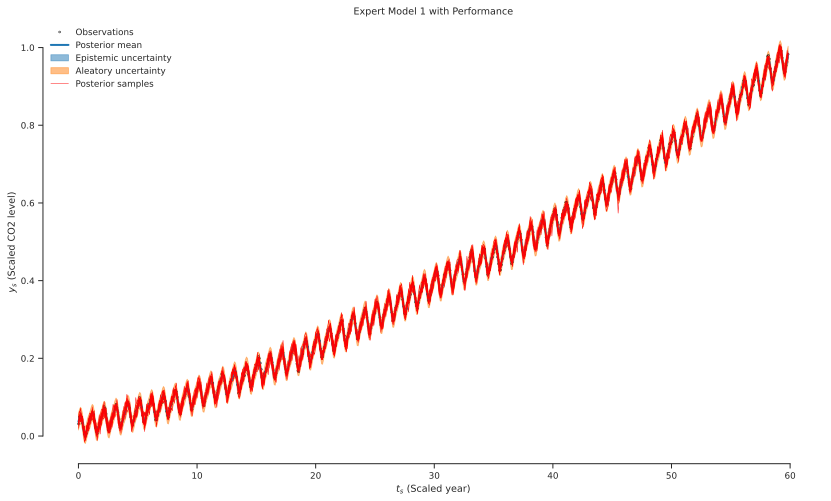

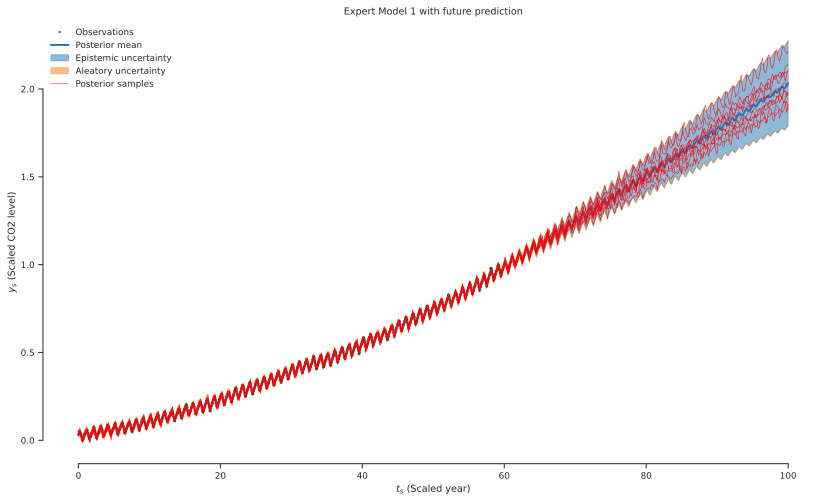

In [ ]:
# A more complex model with more kernels included
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel, ProductKernel, RQKernel, MaternKernel

# Define the Gaussian Process model class
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                 mean_module=gpytorch.means.ConstantMean(),
                 covar_module=ScaleKernel(RBFKernel())):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the covariance function using a combination of kernels

# Long length scale for the overall trend
trend_kernel = RBFKernel(lengthscale= 10.0)

# Periodic component with a 1-year period to capture seasonal variations
seasonal_kernel = PeriodicKernel(period_length=1.0)

# Small length scale for small fluctuations within the period
small_fluctuations_kernel = RBFKernel(lengthscale=0.1)

# Combine small fluctuations and seasonal components
seasonal_fluctuations_kernel = ProductKernel(small_fluctuations_kernel, seasonal_kernel)

# Scale the combined kernel for seasonal fluctuations
scaled_seasonal_fluctuations_kernel = ScaleKernel(seasonal_fluctuations_kernel)

# Additional smooth variations using the Rational Quadratic Kernel
smooth_variations_kernel = RQKernel(lengthscale=1.0, alpha=0.5)

# Rougher variations using the Matérn Kernel
rough_variations_kernel = MaternKernel(lengthscale=1.0, nu=1.5)

# Combine all the components into a single covariance function
cov_module = trend_kernel + scaled_seasonal_fluctuations_kernel * smooth_variations_kernel * rough_variations_kernel

# Define the mean function (Constant Mean)
mean_module = gpytorch.means.ConstantMean()

# Initialize the model with the defined mean and covariance modules
expert_model_2 = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)


# Train the Expert model
train(expert_model_2, train_x, train_y)

# Plot training dataset
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=expert_model_2, x_star=train_x,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');
plt.title("Expert Model 1 with Performance")

# Plot prediction
x_star = torch.linspace(0, 100, 500)
plot_1d_regression(model=expert_model_2, x_star= x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');
plt.title("Expert Model 1 with future prediction")

Plot using the following block:

## Part C - Predicting the future

How does your model predict the future? Why is it better than the naive model?

**Answer:**

The model outperforms the naive model in predicting future data, primarily due to the sophisticated covariance kernels which includes several kernels and mean function it employs. Unlike the naive model, which fails to capture the seasonal fluctuations that occur annually, our two expert models with increasing complexity and additional kernels  incorporates these periodic patterns into the covariance kernel. Additionally, it accounts for both long-term and short-term trends and clearly can do a resaonable job predicting future based on complexity of the model.

## Part D - Bayesian information criterion

As we have seen in earlier lectures, the Bayesian informationc criterion (BIC), see [this](https://en.wikipedia.org/wiki/Bayesian_information_criterion), can bse used to compare two models.
The criterion says that one should:
+ fit the models with maximum likelihood,
+ and compute the quantity:

$$
\text{BIC} = d\ln(n) - 2\ln(\hat{L}),
$$

where $d$ is the number of model parameters, and $\hat{L}$ the maximum likelihood.
+ pick the model with the smallest BIC.

Use BIC to show that the model you constructed in Part C is indeed better than the naïve model of Part A.

**Answer:**

In [ ]:
# Hint: You can find the parameters of a model like this
list(naive_model.hyperparameters())

[Parameter containing:
 tensor([-7.8560], requires_grad=True),
 Parameter containing:
 tensor(0.8225, requires_grad=True),
 Parameter containing:
 tensor(-0.3027, requires_grad=True),
 Parameter containing:
 tensor([[34.8740]], requires_grad=True)]

In [ ]:
m = sum(p.numel() for p in naive_model.hyperparameters())
print(m)

4


In [ ]:
# Hint: You can find the (marginal) log likelihood of a model like this
mll = gpytorch.mlls.ExactMarginalLogLikelihood(naive_model.likelihood, naive_model)
log_like = mll(naive_model(train_x), train_y)
print(log_like)

tensor(2.3862, grad_fn=<DivBackward0>)


In [ ]:
# Hint: The BIC is
bic = -2 * log_like + m * np.log(train_x.shape[0])
print(bic)

tensor(21.5390, grad_fn=<AddBackward0>)


Below I populate all the hyperparameters used in the 3 models and also calculation of BIC scores.

In [ ]:
# Function to calculate the Bayesian Information Criterion (BIC) for all models (including naive and two expert models)
def calculate_bic(model, train_x, train_y):
    # Number of data points
    n = train_x.shape[0]
    # Number of parameters in the model
    m = sum(p.numel() for p in model.parameters())
    # Model's likelihood function
    likelihood = model.likelihood
    # Marginal Log-Likelihood for the model
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    # Calculate the log-likelihood of the model on the training data
    log_likelihood = mll(model(train_x), train_y).item()
    # Calculate the BIC using the formula
    bic = -2 * log_likelihood + m * np.log(n)
    return bic, log_likelihood, m

# Calculate BIC, log-likelihood, and number of hyperparameters for the naive model
bic_naive, log_like_naive, m_naive = calculate_bic(naive_model, train_x, train_y)
# Print named hyperparameters of the naive model
print("------------------Hyperparameters of naive model------------------:")
for p_naive in naive_model.named_hyperparameters():
    print(p_naive)

# Calculate BIC, log-likelihood, and number of hyperparameters for expert model 1
bic_expert_1, log_like_expert_1, m_expert_1 = calculate_bic(expert_model_1, train_x, train_y)
# Print named hyperparameters of expert model 1
print("------------------Hyperparameters of expert model 1------------------:")
for p_expert_1 in expert_model_1.named_hyperparameters():
    print(p_expert_1)

# Calculate BIC, log-likelihood, and number of hyperparameters for expert model 2
bic_expert_2, log_like_expert_2, m_expert_2 = calculate_bic(expert_model_2, train_x, train_y)
# Print named hyperparameters of expert model 2
print("------------------Hyperparameters of expert model 2------------------:")
for p_expert_2 in expert_model_2.named_hyperparameters():
    print(p_expert_2)

# Create a DataFrame to store the results
results = pd.DataFrame({
    "Model": ["Naive Model", "Expert Model 1", "Expert Model 2"],
    "BIC": [bic_naive, bic_expert_1, bic_expert_2],
    "Log-Likelihood": [log_like_naive, log_like_expert_1, log_like_expert_2],
    "Num Hyperparameters": [m_naive, m_expert_1, m_expert_2]
})

# Display the results as a table
print("\nResults:\n")
print(results)

# Compare BIC values to determine the best model according to BIC
best_model = results.loc[results['BIC'].idxmin(), 'Model']
print(f"\nThe best model according to BIC is: {best_model}")


------------------Hyperparameters of naive model------------------:
('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-7.8560], requires_grad=True))
('mean_module.raw_constant', Parameter containing:
tensor(0.8225, requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(-0.3027, requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[34.8740]], requires_grad=True))
------------------Hyperparameters of expert model 1------------------:
('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-50.5342], requires_grad=True))
('mean_module.raw_constant', Parameter containing:
tensor(0.3188, requires_grad=True))
('covar_module.kernels.0.raw_lengthscale', Parameter containing:
tensor([[22.8156]], requires_grad=True))
('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(-1.2750, requires_grad=True))
('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter contain

**Explanation-** The BIC score is higher for the expert models due to scaling and added complexity in the models. When simple GP model is used (BIC score ~ 21), it uses the measurement noise as periodic variation since the periodic variation is too small over long timescale.
When complex models (exper models 1 and 2 with BICs ~ 39 and 59), extra parameters (7 and 10) are used which definitely not only fits the seasonal changes but also helps predict the future. So there is some tradeoffs. Still considering these are within ball park and not massively diffreremt than naive model.



**End of Homework6!**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get update
!sudo apt-get install inkscape texlive-xetex

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 3s (83.2 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to pr

In [ ]:
!sudo apt-get install pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [ ]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/Colab Notebooks/Shaunak_Mukherjee_ME539_homework-06_final.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Shaunak_Mukherjee_ME539_homework-06_final.ipynb to PDF
Failed to get connection
** (inkscape:16390): CRITICAL **: 21:00:24.337: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:16390): CRITICAL **: 21:00:24.337: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:16390): CRITICAL **: 21:00:24.337: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:16394): CRITICAL **: 21:00:24.635: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (inkscape:16394): CRITICAL **: 21:00:24.635: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (inkscape:16394): CRITICAL **: 21:00:24.635: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:16398): CRITICAL **: 21:00:24.942: dbus_g_proxy_new_for_name: assertion 'connection != 